In this notebook, we will use the previously selected scopes to predict the performance of the rest of the search space.

The predictions are based on a 3-feature linear regression model that has been selected and trained by a repeated nested cross-validation scheme.

In [1]:
import sys
import os
import re

sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from tqdm import tqdm
from Code.predictor import ScopeBO
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from rdkit import Chem
import pandas as pd
from itertools import product
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

In [2]:
# define a couple things
objective = "yield"
objectives = ["yield"]
directory = "."
wdir = Path(directory)
datasets = ["high","medium","low"]
fname_search_space = "df_scope.csv"

In [3]:
def get_searchspace(path_results, path_labelled, path_search_space):
    """Function to regenerate the search space csv file from a Benchmark().collect_data() output."""

    # Load the results file
    df_results = pd.read_csv(path_results, index_col=0, header=0)
    # Process the data
    df_results["eval_samples"] = df_results["eval_samples"].apply(lambda x: [y.strip("'") for y in x[1:-1].split(', ')])

    # Get the selected samples
    idx_samples = []
    for idx in df_results.index:
        for sample in df_results.loc[idx,"eval_samples"]:
            idx_samples.append(sample.encode().decode('unicode_escape'))

    # Load the labelled dataframe and remove the objective data for all samples that have not been selected
    df_space = pd.read_csv(path_labelled, index_col=0, header=0)

    idx_pending = df_space.index.difference(idx_samples)
    for objective in objectives:
        df_space.loc[idx_pending, objective] = "PENDING"

    # Save the dataframe
    df_space.to_csv(path_search_space, index=True, header=True)

Run predictions for unseen substrates separately for all random initiations of the different selection methods (ScopeBO, EI, Human-like scope, Clustering Doyle, Clustering Glorius)

Run predictions for ScopeBO

In [4]:
# # progress bar for overall CV manifold progress
# pbar  =tqdm (total = 40 * len(datasets),
#             desc = "Prediction progress")
# model_dict = {}

# # loop through all datasets
# for dset in datasets:
#     fname_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv"

#     # loop through all 40 random seeds
#     for i in range(40):
#         results_file = f"./Results_Data/{dset}-dataset/ei_with-pruning/raw_data/27balanced_b3_V13_s{i}.csv"
    
#         # reconstruct the search space
#         get_searchspace(path_results= wdir / results_file, 
#                         path_labelled = wdir / fname_labelled,
#                         path_search_space = wdir / fname_search_space)
    
#         # run the predictions
#         _,model_params = ScopeBO.predict_performance(filename = wdir / fname_search_space, 
#                                         objective = objective,
#                                         n_feat = 3,  # MLR models with up to 3 features
#                                         repeats_outer = 5, k_outer = 4,  # settings outer CV
#                                         repeats_inner = 10, k_inner = 5,  # settings inner CV
#                                         corr_cutoff = 0.7,  # Pearson correlation cutoff in preprocessing
#                                         fname_pred = "./Results_Data/Predictive_Modeling/Modeling_ScopeBO"\
#                                             f"/pred_scopebo_{dset}_s{i}.csv",  # name of the saved predictions
#                                         directory = directory)
        
#         model_dict[f"{dset}_{i}"] = model_params
        
#         pbar.update(1)  # update tqdm

Run predictions for unseen substrates separately for all random initiations of the regular BO algorithm (EI acq.)

In [5]:
# # progress bar for overall CV manifold progress
# pbar  =tqdm (total = 40 * len(datasets),
#             desc = "Prediction progress")
# model_dict_ei = {}

# # loop through all datasets
# for dset in datasets:
#     fname_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv"

#     # loop through all 40 random seeds
#     for i in range(40):
#         results_file = f"./Results_Data/{dset}-dataset/ei_no-pruning/raw_data/27balanced_b3_V0_s{i}.csv"
    
#         # reconstruct the search space
#         get_searchspace(path_results= wdir / results_file, 
#                         path_labelled = wdir / fname_labelled,
#                         path_search_space = wdir / fname_search_space)
    
#         # run the predictions
#         _, model_params = ScopeBO.predict_performance(filename = wdir / fname_search_space, 
#                                         objective = objective,
#                                         n_feat = 3,  # MLR models with up to 3 features
#                                         repeats_outer = 5, k_outer = 4,  # settings outer CV
#                                         repeats_inner = 10, k_inner = 5,  # settings inner CV
#                                         corr_cutoff = 0.7,  # Pearson correlation cutoff in preprocessing
#                                         fname_pred = "./Results_Data/Predictive_Modeling/Modeling_EI"\
#                                             f"/pred_ei_{dset}_s{i}.csv",  # name of the saved predictions
#                                         directory = directory)
#         model_dict_ei[f"{dset}_{i}"] = model_params
#         pbar.update(1)  # update tqdm

Run predictions for a simulation of conventional selection

In [6]:
# # progress bar for overall CV manifold progress
# pbar  =tqdm (total = 40 * len(datasets),
#             desc = "Prediction progress")
# model_dict_human = {}

# # loop through all datasets
# # for dset in datasets:
# for dset in datasets[:2]:
#     fname_labelled = f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv"

#     # loop through all 40 random seeds
#     for i in range(25):
#         if dset != datasets[1]:
#             continue
#         if i < 21:
#             continue
#         results_file = f"./Results_Data/{dset}-dataset/human-like-acq/raw_data/27greedy_b3_V5_s{i}.csv"
    
#         # reconstruct the search space
#         get_searchspace(path_results= wdir / results_file, 
#                         path_labelled = wdir / fname_labelled,
#                         path_search_space = wdir / fname_search_space)
    
#         # run the predictions
#         _, model_params = ScopeBO.predict_performance(filename = wdir / fname_search_space, 
#                                         objective = objective,
#                                         n_feat = 3,  # MLR models with up to 3 features
#                                         repeats_outer = 5, k_outer = 4,  # settings outer CV
#                                         repeats_inner = 10, k_inner = 5,  # settings inner CV
#                                         corr_cutoff = 0.7,  # Pearson correlation cutoff in preprocessing
#                                         fname_pred = "./Results_Data/Predictive_Modeling/Modeling_Human"\
#                                             f"/pred_human_{dset}_s{i}.csv",  # name of the saved predictions
#                                         directory = directory)
#         model_dict_human[f"{dset}_{i}"] = model_params
#         pbar.update(1)  # update tqdm

Predictions for Doyle clustering with the optimized scope size of 37 samples

In [7]:
# # get predictions for the doyle clustering scope (37 samples - best silhouette score)

# model_params_doyle= {}

# for dset in datasets[1:]:
#     # load the labelled data
#     df_labelled = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",index_col = 0)

#     # load the scope and convert to the search space file
#     df_samples = pd.read_csv(f"./Results_Data/Cluster_Scopes/scope_doyle_samples_{dset}.csv", index_col = 0)
#     pending_idx = df_samples[df_samples["yield"] == "PENDING"].index.tolist()
#     df_search_space = df_labelled.copy()
#     df_search_space.loc[df_search_space.index.isin(pending_idx), "yield"] = "PENDING"
#     # make the input for the prediction run
#     df_search_space.to_csv("df_scope.csv",index=True,header=True)
#     # run the predictions
#     _, model_params = ScopeBO.predict_performance(filename = "df_scope.csv", 
#                                     objective = objective,
#                                     n_feat = 3,  # MLR models with up to 3 features
#                                     repeats_outer = 5, k_outer = 4,  # settings outer CV
#                                     repeats_inner = 10, k_inner = 5,  # settings inner CV
#                                     corr_cutoff = 0.7,  # Pearson correlation cutoff in preprocessing
#                                     fname_pred = "./Results_Data/Predictive_Modeling/Modeling_Clustering"\
#                                         f"/pred_cluster_doyle_{dset}.csv",  # name of the saved predictions
#                                     directory = directory)
#     model_params_doyle[dset] = model_params


Predictions for Doyle clustering conducted with a fixed scope size of 27 samples

In [8]:
# # get predictions for the doyle clustering scope (27 samples - fixed to the same size as the scopebo scope)

# model_params_doyle27= {}

# for dset in datasets:
#     # load the labelled data
#     df_labelled = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",index_col = 0)

#     # load the scope and convert to the search space file
#     df_samples = pd.read_csv(f"./Results_Data/Cluster_Scopes/scope_doyle_samples27_{dset}.csv", index_col = 0)
#     pending_idx = df_samples[df_samples["yield"] == "PENDING"].index.tolist()
#     df_search_space = df_labelled.copy()
#     df_search_space.loc[df_search_space.index.isin(pending_idx), "yield"] = "PENDING"
#     # make the input for the prediction run
#     df_search_space.to_csv("df_scope.csv",index=True,header=True)
#     # run the predictions
#     _, model_params = ScopeBO.predict_performance(filename = "df_scope.csv", 
#                                     objective = objective,
#                                     n_feat = 3,  # MLR models with up to 3 features
#                                     repeats_outer = 5, k_outer = 4,  # settings outer CV
#                                     repeats_inner = 10, k_inner = 5,  # settings inner CV
#                                     corr_cutoff = 0.7,  # Pearson correlation cutoff in preprocessing
#                                     fname_pred = "./Results_Data/Predictive_Modeling/Modeling_Clustering"\
#                                         f"/pred_cluster27_doyle_{dset}.csv",  # name of the saved predictions
#                                     directory = directory)
#     model_params_doyle27[dset] = model_params


Predictions for Glorius clustering

In [9]:
# # get predictions for the glorius clustering scope

# model_params_glorius = {}

# # for dset in datasets:
# for dset in datasets[:2]:

#     # load the labelled data
#     df_labelled = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",index_col = 0)

#     # load the scope
#     df_samples = pd.read_csv(f"./Results_Data/Cluster_Scopes/scope_glorius_smiles_15samples.csv")
#     # canonicalize
#     smiles_samples_prod = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles),canonical=True) 
#                            for smiles in df_samples["smiles"]]

#     # product smiles were used as the glorius algorithm does not work with substrate combinations
#     # the smiles need to be converted to the corresponding reactant pair
#     # Load a df with the substrate pair - product mapping
#     conv = pd.read_csv(f"./../Amide_data/Datasets/Descriptor_Generation/amide_smiles_products_filtered.csv",
#                         names=["Prods","Combs"])
#     # canonicalize
#     conv["Prods"] = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles),canonical=True, isomericSmiles=False) 
#                      for smiles in conv["Prods"]]
#     # convert to substrate combination smiles
#     smiles_samples = [conv.loc[conv["Prods"] == smiles,"Combs"].values[0] for smiles in smiles_samples_prod]
    
#     # assign the samples to the search space dataframe, remove yields for all unseen substrates
#     df_search_space = df_labelled.copy()
#     df_search_space.loc[~df_search_space.index.isin(smiles_samples), "yield"] = "PENDING"

#     # make the input for the prediction run
#     df_search_space.to_csv("df_scope.csv",index=True,header=True)
#     # run the predictions
#     _, model_params = ScopeBO.predict_performance(filename = "df_scope.csv", 
#                                     objective = objective,
#                                     n_feat = 3,  # MLR models with up to 3 features
#                                     repeats_outer = 5, k_outer = 4,  # settings outer CV
#                                     repeats_inner = 10, k_inner = 5,  # settings inner CV
#                                     corr_cutoff = 0.7,  # Pearson correlation cutoff in preprocessing
#                                     fname_pred = "./Results_Data/Predictive_Modeling/Modeling_Clustering"\
#                                         f"/pred_cluster_glorius_{dset}.csv",  # name of the saved predictions
#                                     directory = directory)
#     model_params_glorius[dset] = model_params


With the predictions in hand, we can calculate the root mean squared error for the training (=scope) and test data (= unseen substrates) by comparing the predicted results with the true labels

In [10]:
# import the true labels
dfs_labelled = {dset: pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv", index_col = 0)
                for dset in datasets}

rmse = {}

# Since, the predicted yields are not restricted to the experimental range of 0–100%, we calculated rmse also for the
# modified predictions when a lower prediction limit of 0 and an upper limit of 100 are enforced.
rmse_clipped = {}
dfs_pred = {}

# go through the different random seeds, methods, and datasets
for dset in datasets:
    for method in ["ScopeBO", "Conv. selection","EI"]:
        method_label = method
        if method == "Conv. selection":
            method_label = "Human"
        for i in range(40):
            # read in the predictions
            df_pred = pd.read_csv(f"./Results_Data/Predictive_Modeling/Modeling_{method_label}"\
                                  f"/pred_{method_label.lower()}_{dset}_s{i}.csv", index_col = 0)
            df_pred.rename({"yield": "measured", "yield_pred": "predicted"},axis=1, inplace=True)
            # make a clipped version of the predictions to enforce realistic values (no neg. yields, no yield > 100%)
            df_pred["predicted (clipped)"] = df_pred["predicted"].clip(lower=0, upper=1)

            # map the true labels
            df_pred["true yield"] = dfs_labelled[dset]["yield"]

            # save in a dict
            dfs_pred[f"{method}_{dset}_{i}"] = df_pred

            # calculate the rmse values
            df_train = df_pred.loc[df_pred["measured"] != "PENDING"]
            df_test = df_pred.loc[df_pred["measured"] == "PENDING"]
            rmse[f"{method}_{dset}_{i}_train"] = np.sqrt(mean_squared_error(
                df_train["true yield"], df_train["predicted"]))
            rmse_clipped[f"{method}_{dset}_{i}_train"] = np.sqrt(mean_squared_error(
                df_train["true yield"], df_train["predicted (clipped)"]))
            rmse[f"{method}_{dset}_{i}_test"] = np.sqrt(mean_squared_error(
                df_test["true yield"], df_test["predicted"]))
            rmse_clipped[f"{method}_{dset}_{i}_test"] = np.sqrt(mean_squared_error(
                df_test["true yield"], df_test["predicted (clipped)"]))

In [11]:
# add the clustering predictions separately since they do not have different random seeds

# go through the different random seeds, methods, and datasets
for dset in datasets:
    for method in ["Clustering Doyle", "Clustering Doyle27","Clustering Glorius"]:
        # read in the predictions
        if method == "Clustering Doyle27":
            df_pred = pd.read_csv(f"./Results_Data/Predictive_Modeling/Modeling_Clustering"\
                                f"/pred_cluster27_doyle_{dset}.csv", index_col = 0)
        else:
            df_pred = pd.read_csv(f"./Results_Data/Predictive_Modeling/Modeling_Clustering"\
                                f"/pred_cluster_{method.lower().split(' ')[1]}_{dset}.csv", index_col = 0)
        df_pred.rename({"yield": "measured", "yield_pred": "predicted"},axis=1, inplace=True)
        # make a clipped version of the predictions to enforce realistic values (no neg. yields, no yield > 100%)
        df_pred["predicted (clipped)"] = df_pred["predicted"].clip(lower=0, upper=1)

        # map the true labels
        df_pred["true yield"] = dfs_labelled[dset]["yield"]

        # save in a dict
        dfs_pred[f"{method}_{dset}_{i}"] = df_pred

        # calculate the rmse values
        df_train = df_pred.loc[df_pred["measured"] != "PENDING"]
        df_test = df_pred.loc[df_pred["measured"] == "PENDING"]
        rmse[f"{method}_{dset}_train"] = np.sqrt(mean_squared_error(
            df_train["true yield"], df_train["predicted"]))
        rmse_clipped[f"{method}_{dset}_train"] = np.sqrt(mean_squared_error(
            df_train["true yield"], df_train["predicted (clipped)"]))
        rmse[f"{method}_{dset}_test"] = np.sqrt(mean_squared_error(
            df_test["true yield"], df_test["predicted"]))
        rmse_clipped[f"{method}_{dset}_test"] = np.sqrt(mean_squared_error(
            df_test["true yield"], df_test["predicted (clipped)"]))

Summarize the data

In [12]:
summary = pd.DataFrame(np.nan, index = [f"{method}_{dset}" 
                                        for method,dset in  product(["ScopeBO","Conv. selection","Doyle","Doyle27","Glorius","EI"],datasets)], 
                       columns = [f"{metric}_{stat}" for metric,stat in  product(["Train", "Train (clipped)", 
                                                                                  "Test", "Test (clipped)"],
                                                                                  ["mean", "stdev"])])

for method in ["ScopeBO","Conv. selection","Doyle","Doyle27","Glorius","EI"]:
    for dset in datasets:
        for eval in ["Train","Test"]:
            values = []
            values_clipped = []

            if method not in ["Doyle","Doyle27", "Glorius"]:
                for i in range(40):
                    for key, val in rmse.items():
                        values.append(rmse[f"{method}_{dset}_{i}_{eval.lower()}"])
                        values_clipped.append(rmse_clipped[f"{method}_{dset}_{i}_{eval.lower()}"])
                    summary.loc[f"{method}_{dset}", f"{eval}_mean"] = np.mean(values)
                    summary.loc[f"{method}_{dset}", f"{eval} (clipped)_mean"] = np.mean(values_clipped)
                    summary.loc[f"{method}_{dset}", f"{eval}_stdev"] = np.std(values,ddof=1)
                    summary.loc[f"{method}_{dset}", f"{eval} (clipped)_stdev"] = np.std(values_clipped, ddof=1)
            else:
                summary.loc[f"{method}_{dset}", f"{eval}_mean"] = rmse[f"Clustering {method}_{dset}_{eval.lower()}"]
                summary.loc[f"{method}_{dset}", f"{eval} (clipped)_mean"] = rmse_clipped[f"Clustering {method}_{dset}_{eval.lower()}"]
                summary.loc[f"{method}_{dset}", f"{eval}_stdev"] = 0
                summary.loc[f"{method}_{dset}", f"{eval} (clipped)_stdev"] = 0
             
summary.applymap(lambda x: round(x*100,1))  # times 100 to bring the yields from a [0,1]-scale to a [0,100]-scale

,Train_mean,Train_stdev,Train (clipped)_mean,Train (clipped)_stdev,Test_mean,Test_stdev,Test (clipped)_mean,Test (clipped)_stdev
ScopeBO_high,18.7,2.6,18.7,2.6,30.7,3.4,30.4,3.0
ScopeBO_medium,15.3,2.5,15.3,2.5,26.0,1.8,25.8,1.7
ScopeBO_low,12.3,1.8,12.2,1.8,17.0,1.5,16.7,1.3
Conv. selection_high,17.8,3.0,17.8,3.0,43.0,23.8,33.9,5.4
Conv. selection_medium,16.1,2.1,16.1,2.1,33.4,8.7,29.1,3.6
Conv. selection_low,12.5,2.2,12.5,2.2,23.5,8.1,19.4,4.3
Doyle_high,22.8,0.0,22.8,0.0,30.8,0.0,29.8,0.0
Doyle_medium,18.8,0.0,18.8,0.0,23.3,0.0,23.3,0.0
Doyle_low,13.6,0.0,13.6,0.0,17.2,0.0,17.0,0.0
Doyle27_high,13.8,0.0,13.8,0.0,35.8,0.0,35.1,0.0


Relative RMSEs compared to the one for ScopeBO for the respective dataset

In [13]:
summary_normed = summary[[col for col in summary.columns if "_mean" in col]].copy()

# Split the index into Method and Dataset
summary_normed = summary_normed.reset_index().rename(columns={'index': 'method_dataset'})
summary_normed[['method', 'dataset']] = summary_normed['method_dataset'].str.split('_', expand=True)
summary_normed.drop(columns='method_dataset', inplace=True)

# For each dataset, subtract ScopeBO’s value for each numeric column
numeric_cols = summary_normed.select_dtypes(include='number').columns

def subtract_scopebo(group):
    scopebo_row = group[group['method'] == 'ScopeBO']
    if scopebo_row.empty:
        return group  # leave unchanged if missing
    for col in numeric_cols:
        group[col] = group[col] - scopebo_row[col].values[0]
    return group

summary_normed = summary_normed.groupby('dataset', group_keys=False).apply(subtract_scopebo)

# restore the combined index
summary_normed.index = summary_normed['method'] + "_" + summary_normed['dataset']
summary_normed = summary_normed.drop(columns=['method', 'dataset'])

print("Summary values relative to the ScopeBO value for the respective dataset:")
summary_normed.applymap(lambda x: round(x*100,1))  # times 100 to bring the yields from a [0,1]-scale to a [0,100]-scale

Summary values relative to the ScopeBO value for the respective dataset:


,Train_mean,Train (clipped)_mean,Test_mean,Test (clipped)_mean
ScopeBO_high,0.0,0.0,0.0,0.0
ScopeBO_medium,0.0,0.0,0.0,0.0
ScopeBO_low,0.0,0.0,0.0,0.0
Conv. selection_high,-0.9,-0.9,12.3,3.6
Conv. selection_medium,0.9,0.9,7.4,3.3
Conv. selection_low,0.2,0.3,6.5,2.7
Doyle_high,4.1,4.1,0.1,-0.5
Doyle_medium,3.5,3.5,-2.7,-2.5
Doyle_low,1.3,1.4,0.3,0.3
Doyle27_high,-4.9,-4.9,5.1,4.7


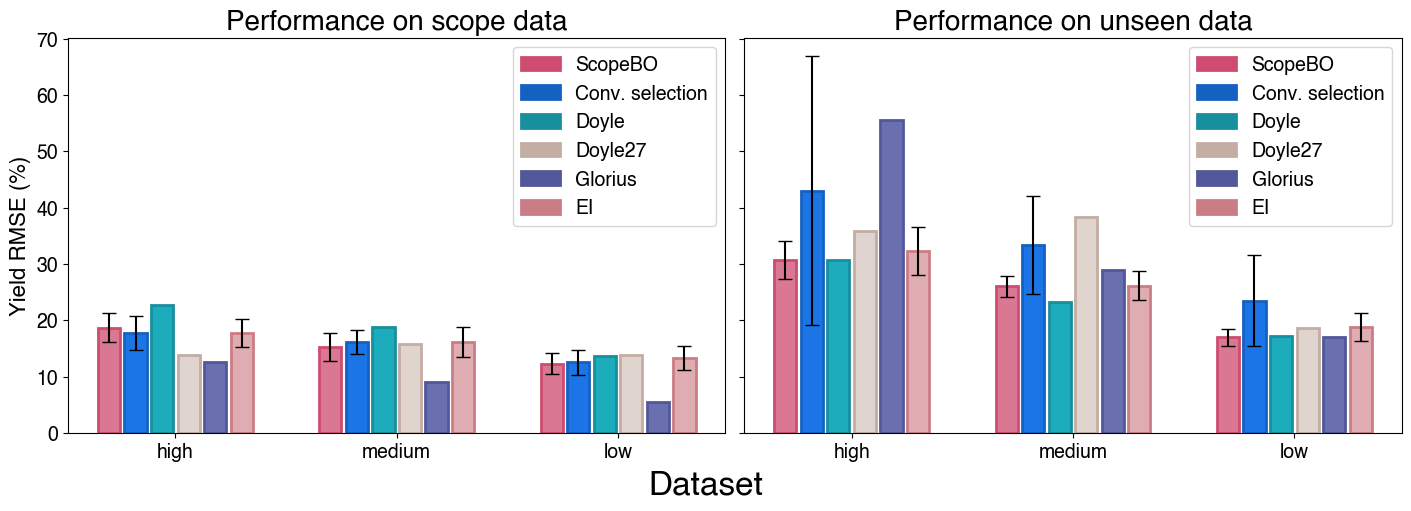

In [14]:
def plot_rmse_summ(columns_to_show, legend_name_map=None, colors=all_colors, width=0.1, figsize=(14, 5),
                   show_legend=True, dpi=100, show_title=True, axis_label_map=None, spacing = 1.2,
                   show_only_test=False, linewidth=2):

    # Filter and scale the data
    df_plot = summary[[col for col in summary.columns if "(clipped)" not in col]]
    df_plot = df_plot.applymap(lambda x: 100 * x)
    
    # Reset index and split method/dataset
    df_plot = df_plot.reset_index()
    df_plot[['method', 'dataset']] = df_plot['index'].str.split('_', expand=True)
    df_plot.drop(columns='index', inplace=True)
    
    # Filter by selected methods
    df_plot = df_plot[df_plot['method'].isin(columns_to_show)]
    
    x = np.arange(len(datasets))

    # Option to only show the test data
    if show_only_test:
        fig, ax = plt.subplots(1, 1, figsize=(figsize[0], figsize[1]), dpi=dpi)
        axes = [None, ax]   # placeholder so index 1 corresponds to "Test"
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True,
                                 constrained_layout=True, dpi=dpi)

    for i, mode in enumerate(['Train', 'Test']):
        
        # Skip Train subplot entirely when show_only_test=True
        if show_only_test and mode == "Train":
            continue
        
        ax = axes[i]
        
        for j, method in enumerate(columns_to_show):
            subset = df_plot[df_plot['method'] == method]
            means = subset[f'{mode}_mean']
            stdevs = subset[f'{mode}_stdev']
            
            label = legend_name_map.get(method, method) if legend_name_map else method
            with_err_bar = [0,1,5]  # only error bars for BO-based methods
            err = stdevs if j in with_err_bar else None

            ax.bar(
                x + (j - (len(columns_to_show) - 1) / 2) * width * spacing,
                means, width, yerr=stdevs, capsize=5 if j in with_err_bar else 0,
                facecolor=adjust_lightness(colors[j], 1.2), edgecolor=colors[j],
                linewidth=linewidth, label=label
            )
        
        ax.set_xticks(x)
        tick_labels = [axis_label_map.get(ds, ds) if axis_label_map else ds for ds in datasets]
        ax.set_xticklabels(tick_labels)
        
        if show_title:
            if mode == "Train":
                ax.set_title("Performance on scope data")
            else:
                ax.set_title("Performance on unseen data")

        # Only put ylabel on leftmost visible plot
        if (not show_only_test and i == 0) or (show_only_test and mode == "Test"):
            ax.set_ylabel("Yield RMSE (%)")

        if show_legend:
            legend_handles = []
            for j, method in enumerate(columns_to_show):
                # edge color = full opacity
                edge_col = colors[j]
                handle = Patch(
                    facecolor=edge_col,
                    edgecolor=edge_col,
                    linewidth=linewidth
                )
                label = legend_name_map.get(method, method) if legend_name_map else method
                legend_handles.append((handle, label))
            ax.legend(
                handles=[h for h, l in legend_handles],
                labels=[l for h, l in legend_handles],
                frameon=True
            )

    if not show_only_test:
        fig.supxlabel("Dataset")

    plt.show()

plot_rmse_summ(columns_to_show=['ScopeBO','Conv. selection', "Doyle","Doyle27", "Glorius",'EI'])


Reprint for manuscript

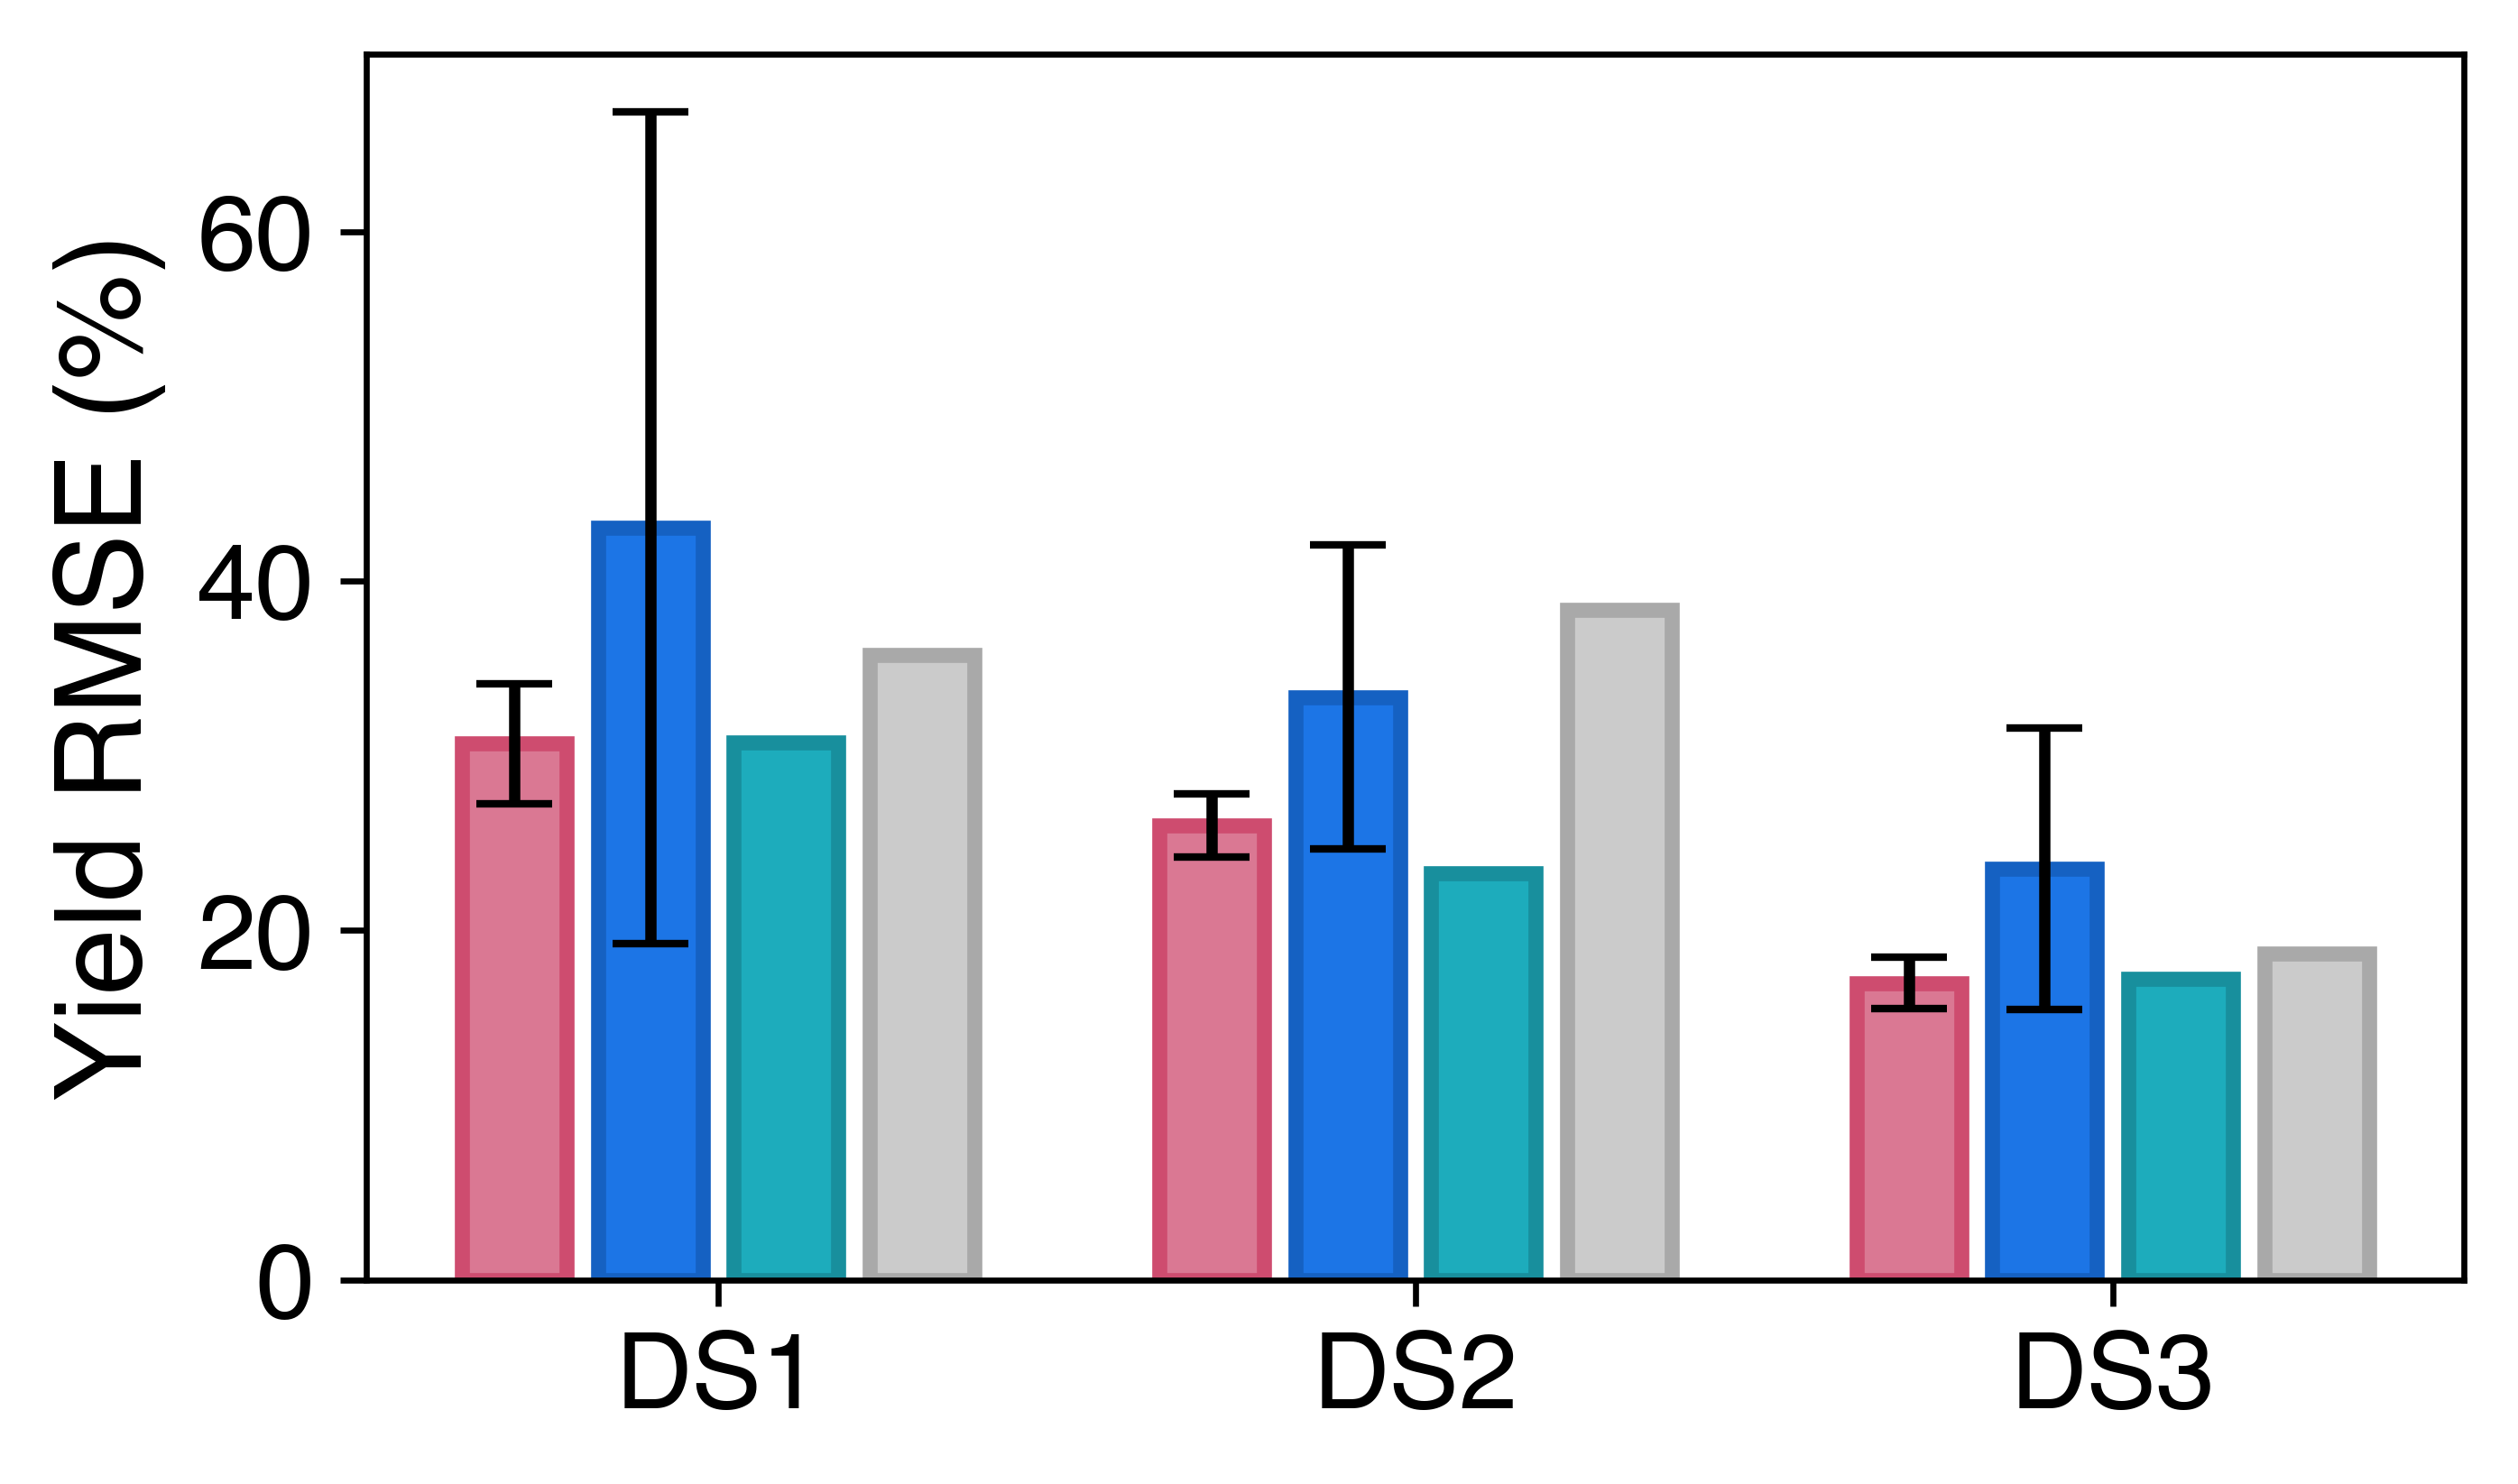

In [15]:
plot_rmse_summ(columns_to_show=['ScopeBO','Conv. selection', "Doyle", "Doyle27"], 
               legend_name_map={"ScopeBO": "ScopeBO", "Conv. selection": "Sim. conventional selection", "Doyle": "Clustering",
                                "Doyle27": "Clustering (27 samples)"},
               figsize= (5, 3), show_legend = False, show_title=False, dpi = 600, width=0.15, spacing = 1.3,
               colors = all_colors[:3] + [all_colors[6]], show_only_test=True, linewidth=2,
               axis_label_map= {"high": "DS1", "medium": "DS2", "low": "DS3"})


### Comparing the RMSE distributions across the random seeds of BO-based methods

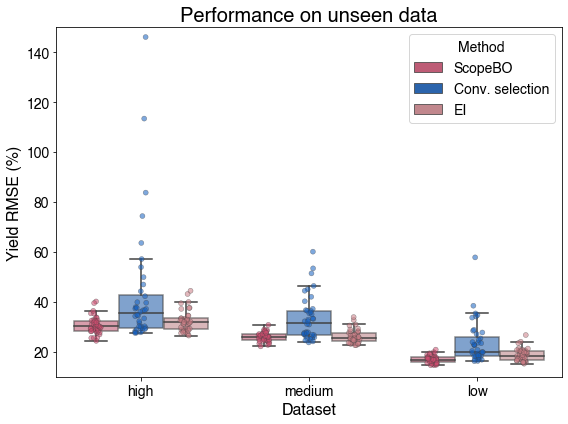

Print again focussing on the boxes


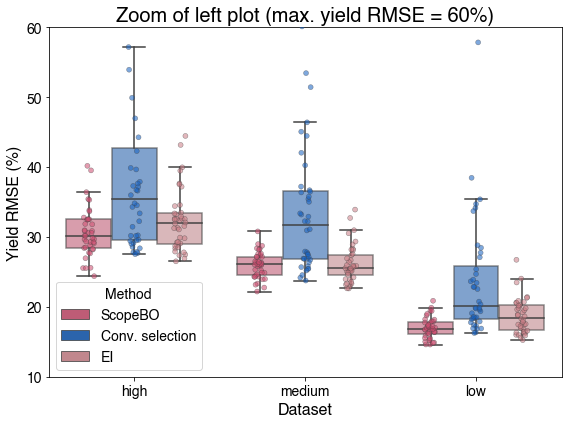

In [16]:
def RMSE_boxplot(rmse,yield_cutoff=150, title = "Performance on unseen data"):
    rows = []
    for k, v in rmse.items():
        if "test" not in k:
            continue

        match = re.match(r"(EI|ScopeBO|Conv. selection)_(high|medium|low)_(\d+)_test", k)
        if match:
            category, level, idx = match.groups()
            rows.append({
                "category": category,
                "level": level,
                "index": int(idx),
                "value": v*100
            })

    df = pd.DataFrame(rows)

    # --- Plot ---
    plt.figure(figsize=(8, 6))

    # Boxplot first (so stripplot overlays)
    sns.boxplot(
        data=df,
        x="level",
        y="value",
        hue="category",
        showcaps=True,
        fliersize=0,  # outliers are shown with stripplot below
        boxprops={'alpha': 0.6},
        palette=doyle_colors[:2] + [doyle_colors[5]]
    )

    # Jittered points on top
    sns.stripplot(
        data=df,
        x="level",
        y="value",
        hue="category",
        dodge=True,
        jitter=True,
        alpha=0.55,
        linewidth=0.5,
        palette=doyle_colors[:2] + [doyle_colors[5]]
    )

    plt.title(title)
    plt.ylim(10,yield_cutoff)
    plt.ylabel("Yield RMSE (%)")
    plt.xlabel("Dataset")

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:3], labels[:3], title="Method")

    plt.tight_layout()
    plt.show()

RMSE_boxplot(rmse=rmse)
print("Print again focussing on the boxes")
RMSE_boxplot(rmse=rmse, yield_cutoff=60, title = "Zoom of left plot (max. yield RMSE = 60%)")


Carry out statistical tests if the results are significantly different

Krsukal-Wallis H test checks if all distributions are the same. If significant, a subsequent pairwise Mann-Whitney U test with Holm-Bonferroni correction is conducted.

In [17]:
for dset in datasets:
    # restrict to rmse for unseen data
    rmse_test = {key:val for key,val in rmse.items() if "test" in key}
    # collect the individual rmse values
    ei_array = np.array([val for key, val in rmse_test.items() if f"EI_{dset}" in key])
    scopebo_array = np.array([val for key, val in rmse_test.items() if f"ScopeBO_{dset}" in key])
    conv_array = np.array([val for key, val in rmse_test.items() if f"Conv. selection_{dset}" in key])
    groups = [scopebo_array, conv_array,ei_array]
    group_names = ["ScopeBO", "Conv. selection", "EI"]
    # kruskal-wallis h test
    statistic, p_value = kruskal(*groups)
    print(f"Results for dataset {dset}:")
    print("Kruskal-Wallis H test")
    print("KW H statistic:", round(statistic,3))
    print(f"p value:", p_value)
    if p_value >= 0.05:
        print("Null hypothesis accepted.\n")
    else:
        print("Null hypothesis rejected.\n")
        pairwise_p = []
        pairwise_u = []
        pair_labels = []

        # mann-whitney u test
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                u, p = mannwhitneyu(groups[i], groups[j], alternative="two-sided")
                pairwise_p.append(p)
                pairwise_u.append(u)
                pair_labels.append(f"{group_names[i]} vs {group_names[j]}")

        # holm correction
        reject, p_corrected, _, _ = multipletests(pairwise_p, method="holm")

        print("Pairwise Mann-Whitney U tests with Holm-Bonferroni correction:")
        for label, u, raw_p, corr_p, rej in zip(pair_labels, pairwise_u, pairwise_p, p_corrected, reject):
            print(f"{label:10s}:  U = {u},  raw p = {raw_p},  Holm p = {corr_p},  reject = {rej}")
        print("\n")
        




Results for dataset high:
Kruskal-Wallis H test
KW H statistic: 13.325
p value: 0.0012782643904769187
Null hypothesis rejected.

Pairwise Mann-Whitney U tests with Holm-Bonferroni correction:
ScopeBO vs Conv. selection:  U = 447.0,  raw p = 0.0006940145128506958,  Holm p = 0.0020820435385520875,  reject = True
ScopeBO vs EI:  U = 630.0,  raw p = 0.10288725776167061,  Holm p = 0.10288725776167061,  reject = False
Conv. selection vs EI:  U = 1051.0,  raw p = 0.015933406541825068,  Holm p = 0.031866813083650136,  reject = True


Results for dataset medium:
Kruskal-Wallis H test
KW H statistic: 28.523
p value: 6.402362074648856e-07
Null hypothesis rejected.

Pairwise Mann-Whitney U tests with Holm-Bonferroni correction:
ScopeBO vs Conv. selection:  U = 325.0,  raw p = 4.974071058738696e-06,  Holm p = 1.0799817244453064e-05,  reject = True
ScopeBO vs EI:  U = 854.5,  raw p = 0.6033296494638039,  Holm p = 0.6033296494638039,  reject = False
Conv. selection vs EI:  U = 1282.0,  raw p = 3.5999